# Training XGBoost to Emulate ec-land

In this notebook we take some example Zarr data (similar to that created by this projects other functionality) and train an ML emulator of the ec-land land surface model. Here we are training on features of climatological, meteorological and previous model state values to predict the 6-hourly model state update 

In [1]:
import xarray as xr
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error


def r2_score_multi(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculated the r-squared score between 2 arrays of values

    :param y_pred: predicted array
    :param y_true: "truth" array
    :return: r-squared metric
    """
    return r2_score(y_pred.flatten(), y_true.flatten())

Open up the mock data zarr file and select a couple of years for training the ML model...

In [2]:
# Open up the Zarr data
ds_ecland = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2018", "2020"))
# Inspect the concatenated dataset and see available model variables
ds_ecland

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 6GB
Dimensions:                     (x: 10051, clim_variable: 23, time: 4384,
                                 variable: 33)
Coordinates:
  * clim_variable               (clim_variable) object 184B 'clim_cell_area' ...
    lat                         (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
    lon                         (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 35kB 2018-01-01 ... 202...
  * variable                    (variable) object 264B 'met_ctpf' ... 'es'
  * x                           (x) int32 40kB 15653 16004 ... 128483 128484
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 925kB dask.array<chunksize=(10051, 23), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    data                        (time, x, variable) float32 6GB dask.array<chunksize=(4, 10051, 33), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_means           (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_mins            (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>

Next we select the "features" and "targets" that we want to use to use in the construction of our ML model. The we select this subset of variables from the dataset

In [3]:
clim_feat_lst = ['clim_clake',
            'clim_ctype',
            'clim_landsea',
            'clim_cu',
            'clim_cvh',
            'clim_cvl',
            'clim_geopot',
            'clim_sdfor',
            'clim_sdor',
            # 'clim_sotype',
            # 'clim_tvh',
            # 'clim_tvl',
            'clim_theta_cap',
            'clim_theta_pwp',
            'clim_veg_covh',
            'clim_veg_covl',
            'clim_veg_z0mh',
            'clim_veg_z0ml',
            'clim_veg_rsminh',
            'clim_veg_rsminl']


feat_lst = ['lai_hv', 
            'lai_lv', 
            'met_ctpf',
            'met_lwdown',
            'met_psurf',
            'met_qair',
            'met_rainf',
            'met_swdown',
            'met_snowf',
            'met_tair',
            'met_wind_e',
            'met_wind_n',
            'swvl1',
            'swvl2',
            'swvl3',
            'stl1',
            'stl2',
            'stl3',
            'snowc',
           ]

targ_lst = ['swvl1',
            'swvl2',
            'swvl3',
            'stl1',
            'stl2',
            'stl3',
            'snowc',
           ]

# Shift the times of the features/targets so that from the previous state we are predicting the next state
clim_feats_ds = (ds_ecland.sel(clim_variable=clim_feat_lst).clim_data
                 .expand_dims(time=ds_ecland.time)
                 .isel(time=slice(0,-1))
                 .stack(z=("x", "time",))
                 .transpose()
                 .rename({"clim_variable": "variable"})
)
feats_ds = ds_ecland.sel(variable=feat_lst).isel(time=slice(0,-1)).data.stack(z=("x", "time",)).transpose()
target_ds = ds_ecland.sel(variable=targ_lst).data

# Select the desired variables, convert to an array, stack the 'time' and 'space' dimensions. 
# For the targets we minus the previous value of the model state so that we are predicting 
# the 6-hourly model update increments instead of the next absolutle model value.
feats_ds = xr.concat((clim_feats_ds, feats_ds), dim="variable").chunk({"variable": -1})
target_ds = target_ds.isel(time=slice(1,None)).stack(z=("x", "time",)).transpose() - target_ds.isel(time=slice(0,-1)).stack(z=("x", "time",)).values.T

In [4]:
# inspect the feautre dataset
feats_ds

<xarray.DataArray 'clim_data' (z: 44053533, variable: 36)> Size: 6GB
dask.array<rechunk-merge, shape=(44053533, 36), dtype=float32, chunksize=(70128, 36), chunktype=numpy.ndarray>
Coordinates:
  * variable  (variable) object 288B 'clim_clake' 'clim_ctype' ... 'snowc'
    lat       (z) float32 176MB dask.array<chunksize=(44053533,), meta=np.ndarray>
    lon       (z) float32 176MB dask.array<chunksize=(44053533,), meta=np.ndarray>
  * z         (z) object 352MB MultiIndex
  * x         (z) int32 176MB 15653 15653 15653 15653 ... 128484 128484 128484
  * time      (z) datetime64[ns] 352MB 2018-01-01 ... 2020-12-31T12:00:00
Attributes:
    history:  Created Fri Oct 13 10:06:00 2023based onsurfclim_all

## Model training with XGBoost

Now we have our "features" and "targets" we can train xgboost to predict our model increments.

In [6]:
%%time
# Set feaures and targets
X = feats_ds.values
y = target_ds.values

# Setup the xgboost model instance and choose some parameters to control the training
model = xgb.XGBRegressor(
    n_estimators=82,
    tree_method="hist",
    device="cuda",
    # objevtive=mean_absolute_error,
    # multi_strategy="multi_output_tree",
    # learning_rate=0.3,
    eval_metric=r2_score_multi,
    # subsample=0.6,
)

print("Fitting XGB model...")
model.fit(X, y, eval_set=[(X, y)])

Fitting XGB model...
[0]	validation_0-rmse:1.45997	validation_0-r2_score_multi:0.33521
[1]	validation_0-rmse:1.22879	validation_0-r2_score_multi:0.52907
[2]	validation_0-rmse:1.06527	validation_0-r2_score_multi:0.64607
[3]	validation_0-rmse:0.95717	validation_0-r2_score_multi:0.71426
[4]	validation_0-rmse:0.88140	validation_0-r2_score_multi:0.75771
[5]	validation_0-rmse:0.82039	validation_0-r2_score_multi:0.79009
[6]	validation_0-rmse:0.76854	validation_0-r2_score_multi:0.81578
[7]	validation_0-rmse:0.72905	validation_0-r2_score_multi:0.83423
[8]	validation_0-rmse:0.69682	validation_0-r2_score_multi:0.84856
[9]	validation_0-rmse:0.67625	validation_0-r2_score_multi:0.85737
[10]	validation_0-rmse:0.65742	validation_0-r2_score_multi:0.86520
[11]	validation_0-rmse:0.64168	validation_0-r2_score_multi:0.87158
[12]	validation_0-rmse:0.62605	validation_0-r2_score_multi:0.87776
[13]	validation_0-rmse:0.60516	validation_0-r2_score_multi:0.88578
[14]	validation_0-rmse:0.59115	validation_0-r2_scor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function r2_score_multi at 0x7f00b0bed580>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=82,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Testing the newly trained emulator

Now that we have our trained ML model we can test it against some independent data. We open up the ML training database and then apply the model over a complete three year period to test how well it performs. The last year here (2022) is completely independent having not been used in the training.

In [6]:
# Open the test data and select a single point in space to run the model on
ds_test = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2018", "2022"))

clim_feats = (ds_test.sel(clim_variable=clim_feat_lst).clim_data
                 .expand_dims(time=ds_test.time)
                 .isel(x=5284, time=slice(0,-1))
                 .rename({"clim_variable": "variable"})
)
feats = ds_test.sel(variable=feat_lst).isel(x=5284, time=slice(0,-1)).data

feats = xr.concat((clim_feats, feats), dim="variable")

In [7]:
# Transform xr.Dataset into a np.ndarray
feats_arr = feats.values

In [8]:
feats_arr.shape

(7179, 36)

In [9]:
# Run the model for a single time to check it works and gives us the desired size output
model.predict(feats_arr[[1]]).shape

/data/conda/envs/ailand/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [19:03:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


(1, 7)

In [10]:
%%time
# Loop over all times and iteratively apply the ML model to construct a 3-year ML estimate to the ec-land model
for x in range(len(feats_arr)-1):
    if x % 1000 == 0:
        print(f"on step {x}...")
    preds = model.predict(feats_arr[[x]])
    feats_arr[x+1, -len(targ_lst):] = np.clip(feats_arr[x, -len(targ_lst):] + preds, 0, None)

on step 0...
on step 1000...
on step 2000...
on step 3000...
on step 4000...
on step 5000...
on step 6000...
on step 7000...
CPU times: user 5min 50s, sys: 8.65 s, total: 5min 59s
Wall time: 45.3 s


## Plotting the results

Now we have 3-year's of output from the ec-land model and from our ML emulator, "ai-land", we can plot both trajectories to see how the ML model performs. As it has been trained on the first 2-years we expect it to fit here. However, the final year was left out of training and so is independent, we see the ML model still performs very well even in this independent year. 

It is also worth noting that here we have performed a complete 3-year run with the "ai-land" model (~4300 applications) and we find very little compounding errors, allowing us to accurately capture the full ec-land climatology.

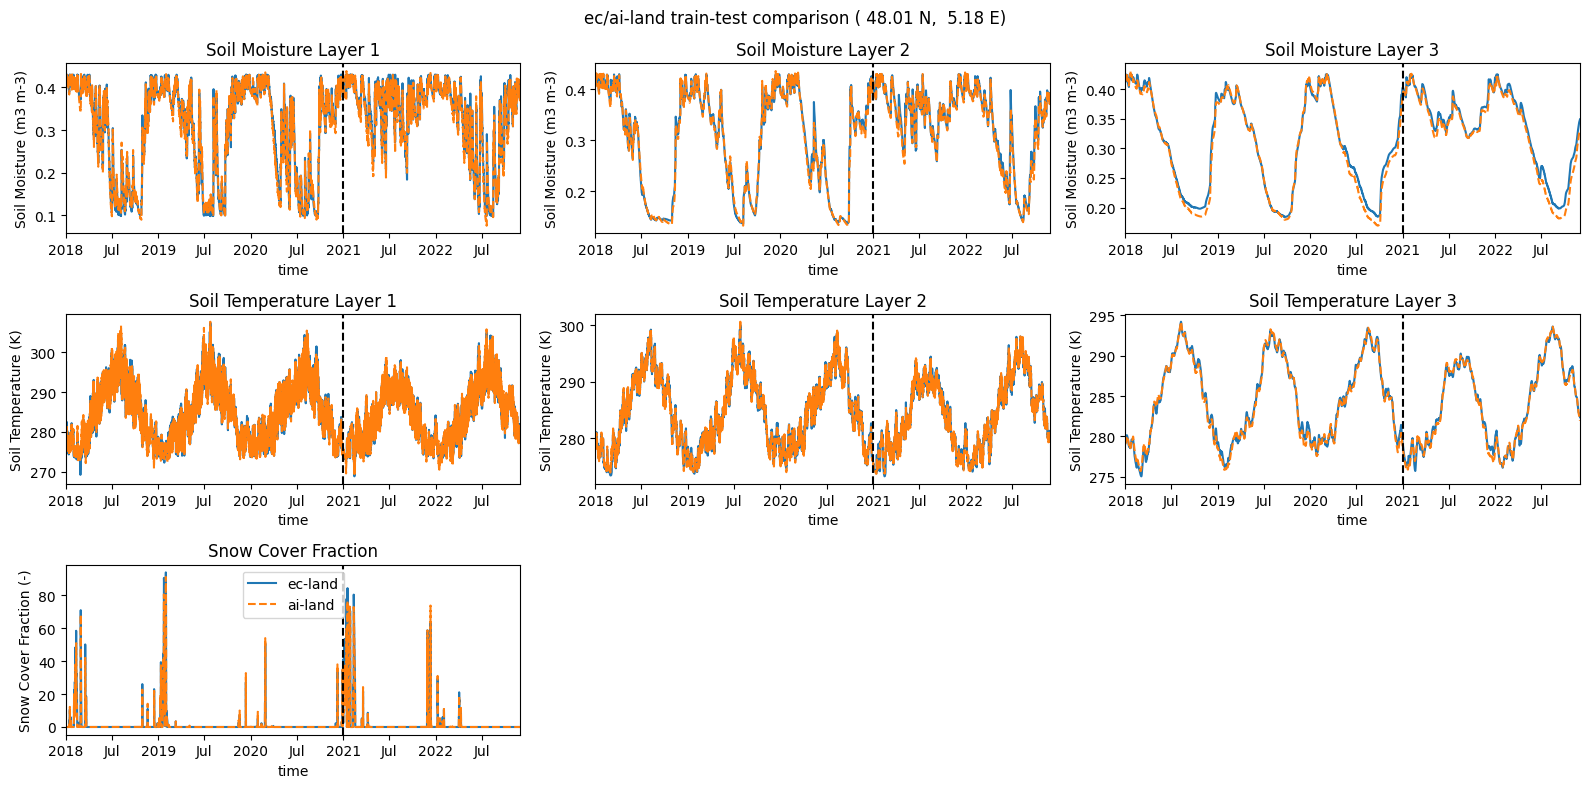

In [11]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)

def ailand_plot(var_name, ax, ylabel, ax_title, test_date="2021-01-01"):
    """Plotting function for the ec-land database and ai-land model output

    :param var_name: parameter variable name
    :param ax: the axes to plot on
    :param ylabel: y-label for plot
    :param ax_title: title for plot
    :param test_date: date to plot vertical line (train/test split), defaults to "2021-01-01"
    :return: plot axes
    """
    feats.sel(variable=var_name).plot(label="ec-land", ax=ax)
    ax.plot(feats.time, feats_arr[:, (clim_feat_lst + feat_lst).index(var_name)], '--', label="ai-land")
    ax.axvline(feats.sel(time=test_date).time.values[0], color="k", linestyle="--")
    ax.set_xlim(feats.time.values[[0,-1]])
    ax.set_ylabel(ylabel)
    ax.set_title(ax_title)
    return ax

ailand_plot("swvl1", ax1, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 1")
ailand_plot("swvl2", ax2, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 2")
ailand_plot("swvl3", ax3, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 3")
ailand_plot("stl1", ax4, "Soil Temperature (K)", "Soil Temperature Layer 1")
ailand_plot("stl2", ax5, "Soil Temperature (K)", "Soil Temperature Layer 2")
ailand_plot("stl3", ax6, "Soil Temperature (K)", "Soil Temperature Layer 3")
ailand_plot("snowc", ax7, "Snow Cover Fraction (-)", "Snow Cover Fraction")

plt.legend()
fig.suptitle(f"ec/ai-land train-test comparison ({feats.lat.values: .2f} N, {feats.lon.values: .2f} E)")
fig.tight_layout()
# fig.savefig("../docs/images/ec-ai-land_comp.png", bbox_inches="tight")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

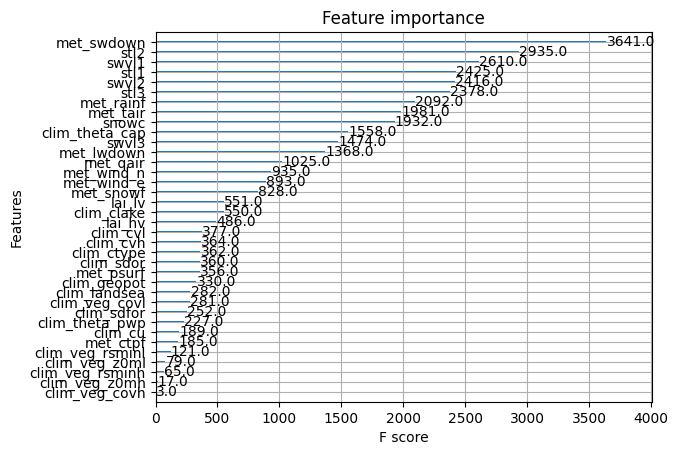

In [12]:
model.get_booster().feature_names = clim_feat_lst + feat_lst
xgb.plot_importance(model)